In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import r2_score

from scipy.interpolate import CubicSpline

# Schematic illustration

In [97]:
def scfa(y, t, k, r, K, a, b, Kb):
    prod,deg,scfa = y
    dydt = [-k*prod, r*deg*(1-deg/K), a*prod-b*deg*scfa/(scfa+Kb)]
    return dydt

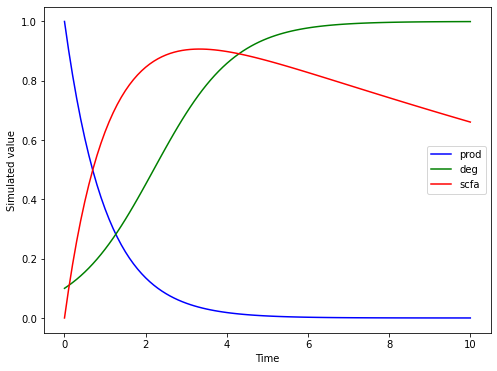

In [102]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1, sharex=True, sharey=True)
y0=[1,0.1,0]
t = np.linspace(0, 10, 101)
k = 1
r = 1
K = 1
a = 1
b = 0.1
Kb = 1
sol = odeint(scfa, y0, t, args=(k, r, K, a, b, Kb))
plt.plot(t, sol[:, 0], 'b', label='prod')
plt.plot(t, sol[:, 1], 'g', label='deg')
plt.plot(t, sol[:, 2], 'r', label='scfa')
plt.xlabel('Time')
plt.ylabel('Simulated value')
plt.legend()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_biphasic_fermentation.svg", format="svg")

# Plot positively and negatively associated taxa

In [2]:
df_16S = pd.read_excel('../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample131,0.0,108301.701888,7101.750943,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,63028.039623,0.0,0.0,0.0,165115.709436,0.0,0.0,0.0,1.322701e+05
sample132,0.0,405068.034693,50064.588558,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,80103.341692,0.0,0.0,0.0,106501.033841,0.0,0.0,0.0,1.003112e+06
sample133,0.0,36169.603950,45332.570284,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,221840.237562,0.0,0.0,0.0,1.866352e+05
sample134,0.0,484302.054587,10150.043060,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,105850.449056,0.0,0.0,0.0,919303.900024,0.0,0.0,0.0,8.714537e+05
sample135,0.0,91489.970533,42374.302141,0.0,0.0,0.0,0.0,0.0,12519.680178,0.0,...,0.0,0.000000,0.0,0.0,0.0,581683.602124,0.0,0.0,0.0,5.335310e+05


In [3]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']
df_joined['Type'] = 'Producer'
df_joined.loc[df_joined.ElasticNet<0,'Type'] = 'Consumer'
df_joined.head()

,SCFA,Taxon,RandomForest,ElasticNet,Type
0,Acetate,Muribaculaceae,0.042678,-0.650962,Consumer
1,Acetate,Akkermansia_dash_muciniphila,0.016252,-0.195898,Consumer
2,Acetate,Bacteroides_dash_acidifaciens,0.021612,0.133174,Producer
3,Acetate,Bacteroides_dash_uniformis,0.010127,-0.217277,Consumer
4,Acetate,Parasutterella,0.034985,-0.091220,Consumer


In [8]:
df_joined[(df_joined.SCFA=='Propionate') & (df_joined.Type=='Consumer')].sort_values(by='RandomForest', ascending=False)

,SCFA,Taxon,RandomForest,ElasticNet,Type
86,Propionate,Bacteroides,0.071111,-4.215720,Consumer
84,Propionate,Parasutterella,0.047326,-1.303477,Consumer
87,Propionate,Clostridia_dash_UCG_dash_014,0.033054,-0.156686,Consumer
80,Propionate,Muribaculaceae,0.024579,-2.750587,Consumer
81,Propionate,Akkermansia_dash_muciniphila,0.022851,-3.178660,Consumer
91,Propionate,Escherichia_dash_Shigella,0.020658,-1.411014,Consumer
88,Propionate,Lachnospiraceae_dash_NK4A136_dash_group,0.012076,-4.895412,Consumer


In [5]:
df_16S_meta = pd.read_excel('../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta = df_16S_meta[(df_16S_meta.Diet=='Inulin') & (df_16S_meta.Vendor!='Beijing')]
for scfa in ['Acetate','Butyrate','Propionate']:
    df_16S_scfa_producer = deepcopy(df_16S)
    df_16S_scfa_consumer = deepcopy(df_16S)
    df_16S_scfa_producer = df_16S_scfa_producer[list(df_joined.loc[(df_joined.SCFA==scfa)&(df_joined.Type=='Producer'),'Taxon'])]
    df_16S_scfa_consumer = df_16S_scfa_consumer[list(df_joined.loc[(df_joined.SCFA==scfa)&(df_joined.Type=='Consumer'),'Taxon'])]
    for c in df_16S_scfa_producer.columns:
        df_16S_scfa_producer[c] *= list(df_joined.loc[(df_joined.SCFA==scfa) & (df_joined.Taxon==c), 'RandomForest'])[0]
    for c in df_16S_scfa_consumer.columns:
        df_16S_scfa_consumer[c] *= list(df_joined.loc[(df_joined.SCFA==scfa) & (df_joined.Taxon==c), 'RandomForest'])[0]
    df_16S_scfa_producer = df_16S_scfa_producer.sum(axis=1).to_frame()
    df_16S_scfa_producer.columns = [scfa+'_Producer']
    df_16S_scfa_consumer = df_16S_scfa_consumer.sum(axis=1).to_frame()
    df_16S_scfa_consumer.columns = [scfa+'_Consumer']
    df_16S_meta = pd.merge(df_16S_meta, df_16S_scfa_producer, left_index=True, right_index=True, how='inner')
    df_16S_meta = pd.merge(df_16S_meta, df_16S_scfa_consumer, left_index=True, right_index=True, how='inner')
df_16S_meta.head()

,MiceID,Vendor,Day,Diet,Acetate_Producer,Acetate_Consumer,Butyrate_Producer,Butyrate_Consumer,Propionate_Producer,Propionate_Consumer
SampleID,,,,,,,,,,
sample411,GI1,Guangdong,0,Inulin,3.139669e+05,7.031459e+05,2.546082e+05,1.111449e+06,6.124732e+05,3.853810e+05
sample412,GI2,Guangdong,0,Inulin,1.258994e+06,1.374761e+06,1.129004e+06,1.994775e+06,2.608066e+06,5.270814e+05
sample413,GI3,Guangdong,0,Inulin,1.607275e+06,1.864928e+06,1.448299e+06,2.717150e+06,3.079373e+06,8.326643e+05
sample414,GI4,Guangdong,0,Inulin,7.603002e+05,1.201901e+06,5.987234e+05,1.903916e+06,1.433460e+06,5.325742e+05
sample426,GI1,Guangdong,1,Inulin,8.410833e+06,5.630112e+06,7.509836e+06,9.629146e+06,1.118939e+07,8.436014e+06


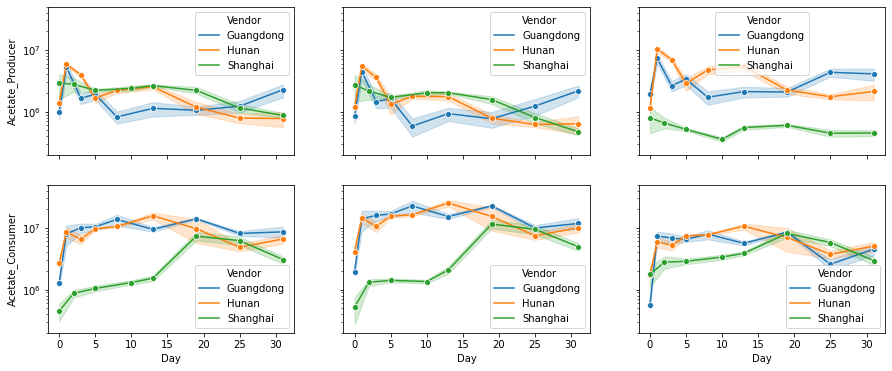

In [103]:
fig, ax = plt.subplots(figsize=(15,6), nrows=2, ncols=3, sharex=True, sharey=True)
for i,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    for j,mtype in enumerate(['Producer','Consumer']):
        sns.lineplot(x='Day',y=scfa+'_'+mtype,hue='Vendor',marker='o',ci=68,data=df_16S_meta,ax=ax[j,i])
        ax[j,i].set_yscale('log')
        ax[j,i].set_ylim([2e5,5e7])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("grouped_scfa_producer_consumer.svg", format="svg")

# Plot most significant SCFA producer

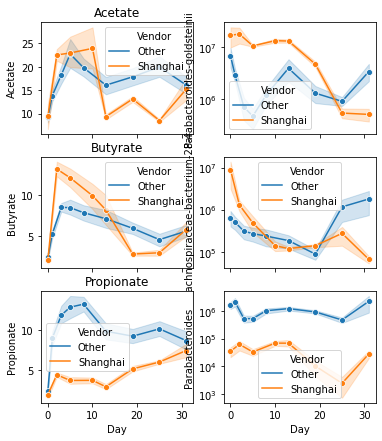

In [15]:
df_16S = pd.read_excel('../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_meta = pd.read_excel('../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta= pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
df_16S_meta = df_16S_meta[(df_16S_meta.Diet=='Inulin') & (df_16S_meta.Vendor!='Beijing') & (df_16S_meta.Day<=500)]
df_16S_meta.loc[df_16S_meta.Vendor!='Shanghai','Vendor'] = 'Other'

# df_qpcr = pd.read_excel('../../../../data/qPCR.xlsx', index_col=0)
# df_qpcr_meta= pd.merge(df_meta, df_qpcr, left_index=True, right_index=True, how='inner')
# df_qpcr_meta = df_qpcr_meta[(df_qpcr_meta.Diet=='Inulin') & (df_qpcr_meta.Vendor!='Beijing')]

df_scfa = pd.read_excel('../../../../data/SCFA.xlsx', index_col=0)
df_scfa_meta= pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[(df_scfa_meta.Diet=='Inulin') & (df_scfa_meta.Vendor!='Beijing') & (df_scfa_meta.Day<=500)]
df_scfa_meta.loc[df_scfa_meta.Vendor!='Shanghai','Vendor'] = 'Other'

fig, ax = plt.subplots(figsize=(6,7), nrows=3, ncols=2, sharex=True)
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    if scfa == 'Acetate':
        producer = 'Parabacteroides-goldsteinii'
    if scfa == 'Butyrate':
        producer = 'Lachnospiraceae-bacterium-28-4'
    if scfa == 'Propionate':
        producer = 'Parabacteroides'
    
    sns.lineplot(x='Day',y=scfa, marker='o', hue='Vendor', ci=68, data=df_scfa_meta, ax=ax[k,0])
    #sns.lineplot(x='Day',y='Value', marker='o', hue='Vendor', ci=68, data=df_qpcr_meta, ax=ax[1,k])
    sns.lineplot(x='Day',y=producer, marker='o', hue='Vendor', ci=68, data=df_16S_meta, ax=ax[k,1])
    ax[k,0].set_title(scfa)
    ax[k,1].set_yscale('log')
    ax[k,1].minorticks_off()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("topscfa_producer.svg", format="svg")

# Correlation between initial SCFA production rate and top SCFA producer absolute abundance

In [49]:
df_scfa = pd.read_excel('../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_meta = pd.read_excel('../../../../data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Vendor != 'Beijing']
df_meta = df_meta[df_meta.Diet == 'Inulin']
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.MiceID):
    curr_df = df_scfa_meta[df_scfa_meta.MiceID==curr_mice]
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.MiceID==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv_meta = pd.merge(df_meta, df_scfa_deriv, left_index=True, right_index=True, how='inner')
df_scfa_deriv_meta = df_scfa_deriv_meta[df_scfa_deriv_meta.Day==0]
df_scfa_deriv_meta.head()

,MiceID,Vendor,Day,Diet,Acetate,Butyrate,Propionate
SampleID,,,,,,,
sample411,GI1,Guangdong,0,Inulin,-11.331097,-1.456967,1.658890
sample412,GI2,Guangdong,0,Inulin,4.127181,3.888098,13.125370
sample413,GI3,Guangdong,0,Inulin,11.745672,5.345893,14.519866
sample414,GI4,Guangdong,0,Inulin,14.622299,4.552023,11.448899
sample276,HI1,Hunan,0,Inulin,20.455523,5.831758,20.789510


In [50]:
df_16S = pd.read_excel('../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S = df_16S[['Parabacteroides_dash_goldsteinii','Lachnospiraceae_dash_bacterium_dash_28_dash_4','Parabacteroides']]
#df_16S = np.log10(df_16S)
df_scfa_deriv_meta = pd.merge(df_scfa_deriv_meta, df_16S, left_index=True, right_index=True, how='left')
df_scfa_deriv_meta

,MiceID,Vendor,Day,Diet,Acetate,Butyrate,Propionate,Parabacteroides_dash_goldsteinii,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Parabacteroides
SampleID,,,,,,,,,,
sample411,GI1,Guangdong,0,Inulin,-11.331097,-1.456967,1.658890,8.170217e+04,4.846739e+04,1.303080e+06
sample412,GI2,Guangdong,0,Inulin,4.127181,3.888098,13.125370,2.847630e+05,1.469417e+05,4.185306e+06
sample413,GI3,Guangdong,0,Inulin,11.745672,5.345893,14.519866,2.784230e+05,1.338572e+05,2.580767e+06
sample414,GI4,Guangdong,0,Inulin,14.622299,4.552023,11.448899,1.002871e+05,9.560083e+04,8.097952e+05
sample276,HI1,Hunan,0,Inulin,20.455523,5.831758,20.789510,9.360225e+06,1.489209e+06,2.729612e+06
sample277,HI2,Hunan,0,Inulin,15.751307,5.226445,11.021310,2.244384e+07,1.146453e+06,3.710512e+05
sample279,HI4,Hunan,0,Inulin,-4.475352,-1.359143,-0.383382,1.578915e+07,8.691080e+04,9.878155e+05
sample280,HI5,Hunan,0,Inulin,-0.860828,3.418568,2.514472,6.053610e+06,2.027740e+06,2.111425e+05
sample31,SI1,Shanghai,0,Inulin,13.108329,10.084796,3.849963,2.089208e+07,7.153537e+06,7.999057e+04


In [59]:
pearsonr(df_scfa_deriv_meta['Parabacteroides_dash_goldsteinii'],df_scfa_deriv_meta['Acetate'])

(0.44175340541879266, 0.13071297321240824)

In [60]:
pearsonr(df_scfa_deriv_meta['Lachnospiraceae_dash_bacterium_dash_28_dash_4'],df_scfa_deriv_meta['Butyrate'])

(0.5020866734343266, 0.0803943319425665)

In [61]:
pearsonr(df_scfa_deriv_meta['Parabacteroides'],df_scfa_deriv_meta['Propionate'])

(0.7146532895449572, 0.00605009795049084)

(-1000000.0, 10000000.0)

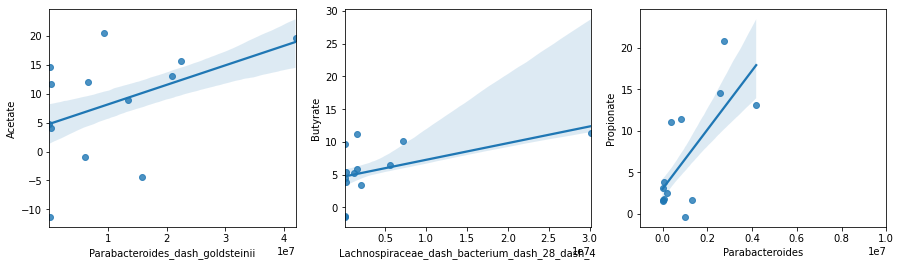

In [66]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

sns.regplot(x='Parabacteroides_dash_goldsteinii',y='Acetate',ci=68,data=df_scfa_deriv_meta, ax=ax[0])

sns.regplot(x='Lachnospiraceae_dash_bacterium_dash_28_dash_4',y='Butyrate', ci=68,data=df_scfa_deriv_meta, ax=ax[1])

sns.regplot(x='Parabacteroides',y='Propionate',data=df_scfa_deriv_meta, ax=ax[2],ci=68)
ax[2].set_xlim([-1e6,1e7])